In [1]:
## Plots Empirical CAPEX of energy techs and estimated CAPEX of Fusion + learning

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter, FuncFormatter




C:\Users\lintang\AppData\Local\Temp\ipykernel_27532\3765172672.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  er = float(er)
C:\Users\lintang\AppData\Local\Temp\ipykernel_27532\3765172672.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(x)
C:\Users\lintang\AppData\Local\Temp\ipykernel_27532\3765172672.py:43: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(y)
C:\Users\lintang\AppData\Local\Temp\ipykernel_27532\3765172672.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x_end = float(x_end)


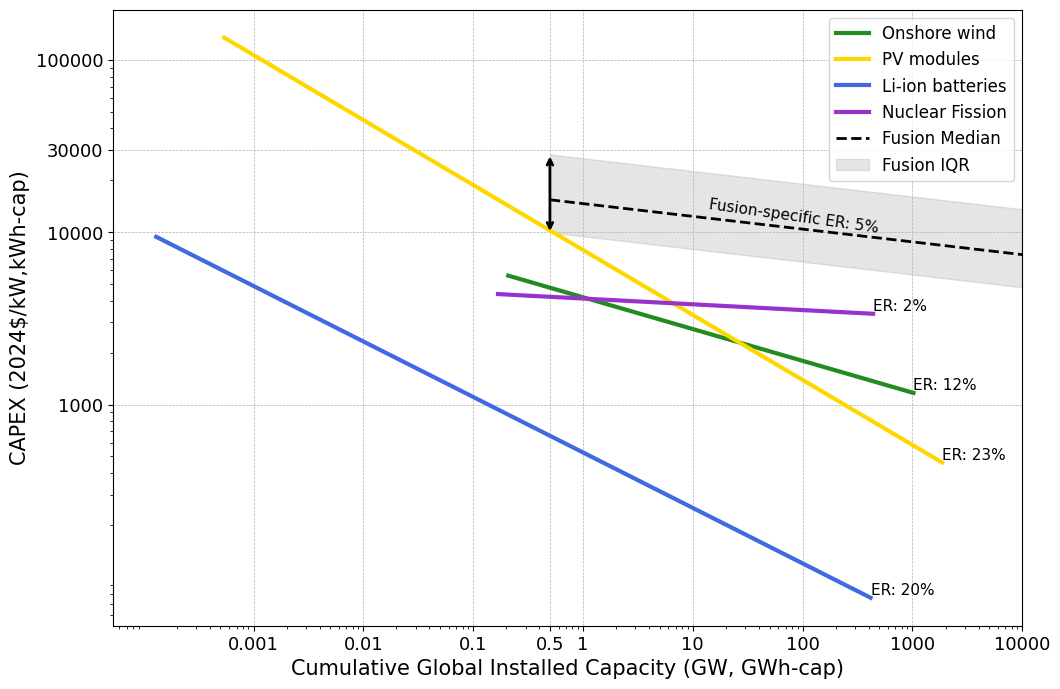

In [3]:
## Plot wind, SPV and li-ion

# Load the Excel file
file_path = 'Non-nuclear Data.xlsx'  # Replace with your actual file path
excel_data = pd.ExcelFile(file_path)
df = excel_data.parse('InputData')

# Extract x and y values
x_wind = df[df['Technology']=='Onshore Wind']['Starting cumulative cap (GW)']
y_wind = df[df['Technology']=='Onshore Wind']['Starting Cost (2024$/kW)']
er_wind = df[df['Technology']=='Onshore Wind']['Experience rate']
x_end_wind = df[df['Technology']=='Onshore Wind']['End cumulative cap']

x_spv = df[df['Technology']=='PV modules']['Starting cumulative cap (GW)']
y_spv = df[df['Technology']=='PV modules']['Starting Cost (2024$/kW)']
er_spv = df[df['Technology']=='PV modules']['Experience rate']
x_end_spv = df[df['Technology']=='PV modules']['End cumulative cap']


x_batt = df[df['Technology']=='Li-ion batteries']['Starting cumulative cap (GW)']
y_batt = df[df['Technology']=='Li-ion batteries']['Starting Cost (2024$/kW)']
er_batt = df[df['Technology']=='Li-ion batteries']['Experience rate']
x_end_batt = df[df['Technology']=='Li-ion batteries']['End cumulative cap']


# Organize data
tech_data = {
    'Onshore wind': (x_wind, y_wind,er_wind,x_end_wind,'forestgreen'),
    'PV modules': (x_spv, y_spv,er_spv,x_end_spv,'gold'),
    'Li-ion batteries': (x_batt,y_batt,er_batt,x_end_batt,'royalblue')
}

plt.figure(figsize=(10, 7))


for tech, (x, y,er,x_end, colour) in tech_data.items():

    # Calculate slope for log-log plot: slope = log2(1 - LR)
    er = float(er)
    slope_new = np.log2(1 - er)

    x = float(x)
    y = float(y)
    x_end = float(x_end)
    x_new = np.linspace(x,x_end,1000)
    y_new = y * (x_new/x) ** slope_new


    plt.plot(x_new, y_new, label=f"{tech}",color = f"{colour}",linewidth=3)

    # Annotate learning rate on the plot
    plt.text(x_end, y_new[-1], f"ER: {er*100:.0f}%", fontsize=11,ha='left', va='bottom')


## Plot nuclear fission

# Load the Excel file
file_path = 'Nuclear Data.xlsx'  # Replace with your actual file path
excel_data = pd.ExcelFile(file_path)
df = excel_data.parse('Nuclear')
df = df.dropna()              
x_nuclear = df['Cumulative Global Capacity (GW)']
y_nuclear = df['OCC (2024$/kW)']     

valid = (x_nuclear > 0) & (y_nuclear > 0)
x_clean = x_nuclear[valid]
y_clean = y_nuclear[valid]

# Fit log-log data
log_x = np.log10(x_clean)
log_y = np.log10(y_clean)
slope, intercept = np.polyfit(log_x, log_y, 1)

# Learning rate: LR = 1 - 2^slope
lr = 1 - 2 ** slope

# Generate fitted y values
x_fit = np.linspace(x_clean.min(), x_clean.max(), 10000)
y_fit = 10 ** (intercept + slope * np.log10(x_fit))

# Plot original data and fit
#plt.scatter(x_clean, y_clean, color = f"{colour}",s=12)
plt.plot(x_fit, y_fit, label='Nuclear Fission',color = 'darkorchid',linewidth=3)

# Annotate learning rate on the plot
x_annotate = x_fit[-1]
y_annotate = y_fit[-1]
plt.text(x_annotate, y_annotate, f"ER: {lr*100:.0f}%", fontsize=11,ha='left', va='bottom')



## Plot fusion
fusion_er = 0.05
starting_cap = 0.5    #in GW


# Set starting cost to cost of fusion at 1 GW
fusion_high_start = 29766*(1-fusion_er)     
fusion_low_start = 10500*(1-fusion_er)
fusion_median = 16236*(1-fusion_er)

# Calculate slope for log-log plot: slope = log2(1 - LR)
slope_new = np.log2(1 - fusion_er)

# Generate cumulative capacity values (GW)
x_new = np.linspace(starting_cap, 10000, 1000)  # from 0.5 GW to 10000 GW

# Calculate cost based on learning curve

y_low = fusion_low_start* (x_new/starting_cap)**slope_new
y_high = fusion_high_start* (x_new/starting_cap)**slope_new
y_med = fusion_median* (x_new/starting_cap)**slope_new

# Plot fusion curves
plt.plot(x_new, y_med, '--', color='black', linewidth=2, label='Fusion Median')
plt.fill_between(x_new, y_low, y_high, color='gray', alpha=0.2, label='Fusion IQR')
      
# Write texts
plt.text(500, 16000, "Fusion-specific ER: 5%", fontsize=11, ha='right', va='top', color='black', rotation = -8)
#plt.text(x_new[0]-0.1, y_high[0]-5000, "First FPP Estimate Range", fontsize=13, ha='right', va='top', color='black', rotation = 90)

# plot starting cost uncertainty
plt.annotate('', xy=(x_new[0], y_high[0]+300), xytext=(x_new[0], y_low[0]-200),
             arrowprops=dict(arrowstyle='<->', lw=2, color='black'))


## Figure parameters
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Cumulative Global Installed Capacity (GW, GWh-cap)", fontsize=15)
plt.ylabel("CAPEX (2024$/kW,kWh-cap)", fontsize=15)
plt.legend(fontsize = 12)
plt.grid(True, which='major', ls='--', lw=0.5)
plt.tight_layout()
plt.xlim(right=10000)
#plt.ylim(bottom=1000)

# Apply ScalarFormatter to show whole numbers
for axis in [plt.gca().xaxis, plt.gca().yaxis]:
    axis.set_major_formatter(ScalarFormatter())

# Custom formatter for x-axis
def x_custom_formatter(x, pos):
    if x ==0.001:
        return f"{x:.3f}"  # Show 0.1 with 3 d.p.
    elif x == 0.01:
        return f"{x:.2f}"  # Show 0.1 with 2 d.p.
    elif x == 0.1 or x == 0.5:
        return f"{x:.1f}"  # Show 0.1 with 1 d.p.
    else:
        return f"{int(x)}"  # Show others as integers (0 d.p.)
    
# Custom formatter for y-axis
def y_custom_formatter(y, pos):
    if y == 0.1:
        return f"{y:.1f}"  # Show 0.1 with 1 d.p.
    else:
        return f"{int(y)}"  # Show others as integers (0 d.p.)

plt.gca().xaxis.set_major_formatter(FuncFormatter(x_custom_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_custom_formatter))
plt.xticks(fontsize=13)  # X-axis tick labels
plt.yticks(fontsize=13)  # Y-axis tick labels

# Optional: Force specific tick locations (if needed)
plt.gca().set_xticks([0.001,0.01,0.1, 0.5, 1, 10, 100,1000,10000])
plt.gca().set_yticks([1000,10000,30000,100000])
plt.show()